In [1]:
import os
import tensorflow as tf
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.3.0


In [3]:
# import csv files
# problem with this method is that it imports in a weird order, as in jan 1 is not always the first file imported, and jan 2 won't be the second even if jan 1 is the first
data_dir = '/home/acapskyrim/projects/psm/psm_generate/data'
combined_data = pd.DataFrame()
counter = 0 # this is just for getting pretty plots

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), parse_dates=[0])
    dataset.columns = ['Time', 'Beacon_1', 'Beacon_2', 'Beacon_3', 'Beacon_4', 'Beacon_5']
    combined_data = combined_data.append(dataset)
#     counter = counter + 1
#     if counter == 1:
#         break

combined_data.set_index('Time', inplace=True)

In [4]:
# set train and test samples
train_size = int(len(combined_data) * 0.90)
test_size = len(combined_data) - train_size
train, test = combined_data.iloc[0:train_size], combined_data.iloc[train_size:len(combined_data)]
print(train.shape, test.shape)

(7576, 5) (842, 5)


In [ ]:
# visualize data
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Beacon_1'], label="Beacon 1", color='blue', animated=True, linewidth=1)
ax.plot(train['Beacon_2'], label="Beacon 3", color='red', animated=True, linewidth=1)
ax.plot(train['Beacon_3'], label="Beacon 3", color='green', animated=True, linewidth=1)
ax.plot(train['Beacon_4'], label="Beacon 4", color='black', animated=True, linewidth=1)
ax.plot(train['Beacon_5'], label="Beacon 5", color='yellow', animated=True, linewidth=1)

plt.legend(loc='lower left')
plt.show()

In [ ]:
# fourier transforms. just out of curiosity
train_fft = np.fft.fft(train)
test_fft = np.fft.fft(test)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label="Beacon 1", color='blue', animated=True, linewidth=1)
ax.plot(train_fft[:,1].real, label="Beacon 3", color='red', animated=True, linewidth=1)
ax.plot(train_fft[:,2].real, label="Beacon 3", color='green', animated=True, linewidth=1)
ax.plot(train_fft[:,3].real, label="Beacon 4", color='black', animated=True, linewidth=1)
ax.plot(train_fft[:,4].real, label="Beacon 5", color='yellow', animated=True, linewidth=1)

plt.legend(loc='lower left')
plt.show()

In [5]:
#reserved for normalization if needed
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train)
x_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [6]:
#reshaping the data
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [7]:
#can't reshape an already reshaped shape. so printing is in separate cell
print("Train shape: ", x_train.shape)
print("Test shape: ", x_test.shape)
num_features = x_train.shape[2]

Train shape:  (7576, 1, 5)
Test shape:  (842, 1, 5)


In [8]:
# Here's the fun stuff. Neural network definition. we usin autoencoders for this
# first one is using LSTM, more with others later
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, callbacks

def autoencoder_model(x, num):
    inputs = Input(shape=(x.shape[1], x.shape[2]))
    l1 = LSTM(num*num, activation='relu', return_sequences=True,
             kernel_regularizer=regularizers.l2(0.00))(inputs)
    l2 = LSTM(num, activation='relu', return_sequences=False)(l1)
    l3 = RepeatVector(x.shape[1])(l2)
    l4 = LSTM(num, activation='relu', return_sequences=True)(l3)
    l5 = LSTM(num*num, activation='relu', return_sequences=True)(l4)
    output = TimeDistributed(Dense(x.shape[2]))(l5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [9]:
# let's actually build the network
model = autoencoder_model(x_train, num_features)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 5)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 25)             3100      
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 620       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 5)              220       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 25)             3100      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 5)             

In [10]:
# training time
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode="min", restore_best_weights=True, min_delta=0.0005, patience=5)
nb_epochs = 100
batch_size = 10
history = model.fit(x_train, x_train, epochs=nb_epochs, batch_size=batch_size,
                   validation_split=0.1, callbacks=[callback]).history
len(history['loss'])

Epoch 1/100
682/682 [==============================] - 9s 13ms/step - loss: 0.1625 - val_loss: 0.0905
Epoch 2/100
682/682 [==============================] - 8s 12ms/step - loss: 0.0754 - val_loss: 0.0561
Epoch 3/100
682/682 [==============================] - 9s 13ms/step - loss: 0.0480 - val_loss: 0.0455
Epoch 4/100
682/682 [==============================] - 8s 12ms/step - loss: 0.0410 - val_loss: 0.0372
Epoch 5/100
682/682 [==============================] - 9s 13ms/step - loss: 0.0354 - val_loss: 0.0350
Epoch 6/100
682/682 [==============================] - 8s 12ms/step - loss: 0.0339 - val_loss: 0.0344
Epoch 7/100
682/682 [==============================] - 8s 12ms/step - loss: 0.0322 - val_loss: 0.0315
Epoch 8/100
682/682 [==============================] - 8s 12ms/step - loss: 0.0303 - val_loss: 0.0307
Epoch 9/100
682/682 [==============================] - 9s 13ms/step - loss: 0.0289 - val_loss: 0.0287
Epoch 10/100
682/682 [==============================] - 8s 12ms/step - loss: 0.027

39

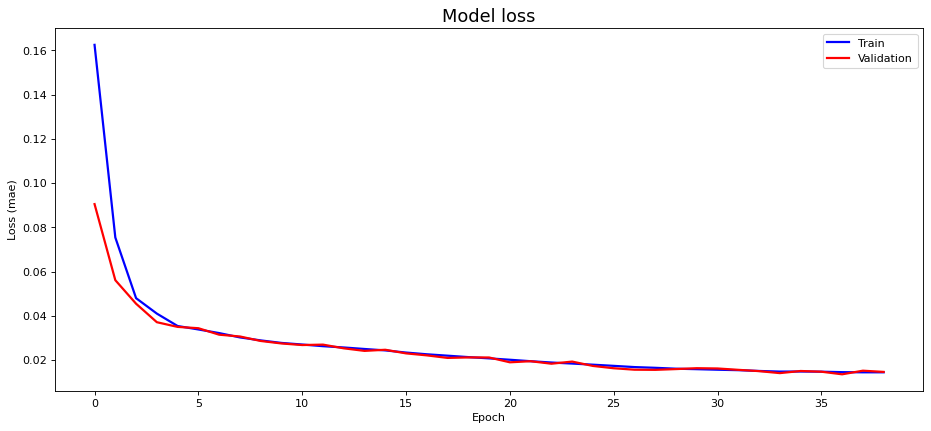

In [11]:
fig, ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(-0.1, 0.1)

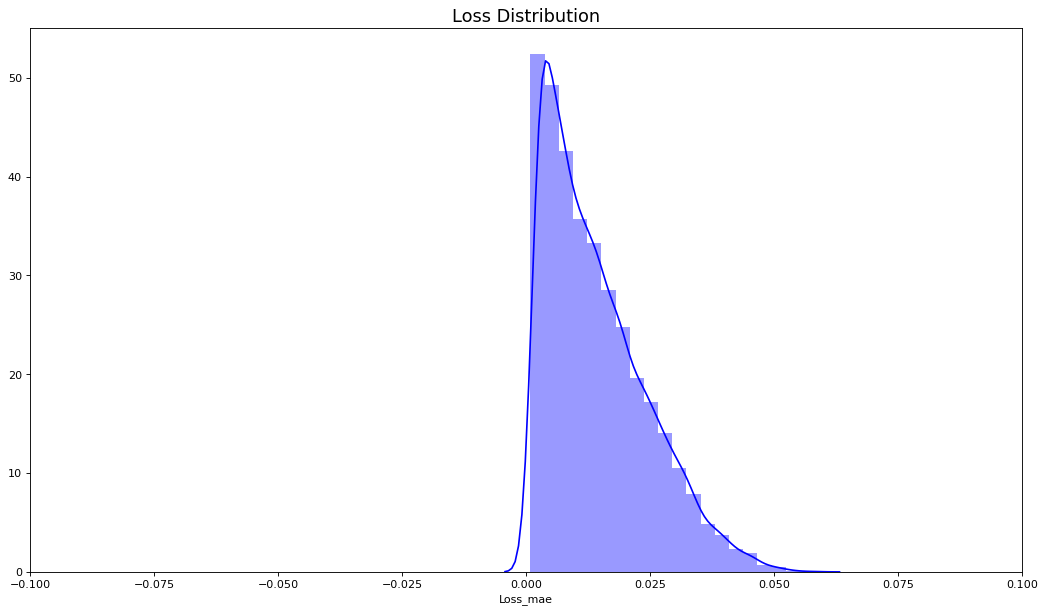

In [15]:
# loss distribution to determine threshold for anomaly
x_pred = model.predict(x_train)
x_pred = x_pred.reshape(x_pred.shape[0], x_pred.shape[2])
x_pred = pd.DataFrame(x_pred, columns=train.columns)
x_pred.index = train.index

scored = pd.DataFrame(index=train.index)
xtrain = x_train.reshape(x_train.shape[0], x_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(x_pred - xtrain), axis=1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue');
plt.xlim([-0.1, 0.1])